 Loading file: /content/1.rst
 Displacement data loaded.
 Stress data loaded.
 Found 579 elements and 1942 nodes.
 Extracted 579 elements with features.

 Active Learning Iteration 1
  Queried 20 new elements. Total labeled: 70

 Active Learning Iteration 2
  Queried 20 new elements. Total labeled: 90

 Active Learning Iteration 3
  Queried 20 new elements. Total labeled: 110

 Active Learning Iteration 4
  Queried 20 new elements. Total labeled: 130

 Active Learning Iteration 5
  Queried 20 new elements. Total labeled: 150

 Active Learning Iteration 6
  Queried 20 new elements. Total labeled: 170

 Active Learning Iteration 7
  Queried 20 new elements. Total labeled: 190

 Active Learning Iteration 8
  Queried 20 new elements. Total labeled: 210

 Results saved to mesh_refinement_predictions.csv

 Evaluation on oracle labels:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       579

    accuracy                           1.00      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


 Saved visualization to refinement_map.png


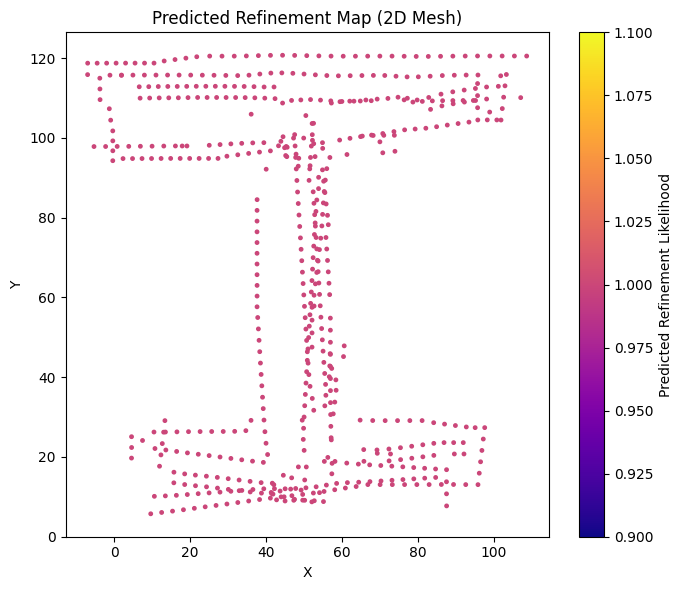

In [2]:

!pip install ansys-mapdl-reader

import os
import numpy as np
import pandas as pd
from ansys.mapdl.reader import read_binary
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

rst_file = "/content/1.rst"
RANDOM_STATE = 42

INITIAL_LABELS = 50
QUERY_BATCH = 20
MAX_QUERIES = 200

STRESS_GRAD_THRESHOLD = 5e-3
DISP_GRAD_THRESHOLD = 1e-3
ELEMENT_SIZE_WEIGHT = 0.3


def load_result(path):
    """Load .rst file and return result object."""
    print(f" Loading file: {path}")
    return read_binary(path)

def centroid(coords):
    """Compute centroid from node coordinates."""
    return np.mean(coords, axis=0)

def element_size(coords):
    """Estimate element size by max edge length."""
    maxd = 0.0
    n = len(coords)
    for i in range(n):
        for j in range(i + 1, n):
            d = np.linalg.norm(coords[i] - coords[j])
            maxd = max(maxd, d)
    return maxd

def average_over_nodes(node_ids, value_map):
    vals = [value_map[n] for n in node_ids if n in value_map]
    return np.mean(vals) if vals else np.nan


def build_dataset(result):
    mesh = result.mesh
    rows = []

    disp_map, stress_map = {}, {}

    try:
        nid, disp = result.nodal_displacement(0)
        disp_mag = np.linalg.norm(disp, axis=1) if np.ndim(disp) == 2 else np.abs(disp)
        disp_map = dict(zip(nid, disp_mag))
        print(" Displacement data loaded.")
    except Exception as e:
        print(" No displacement data found:", e)

    try:
        nid, stress = result.nodal_stress(0)
        s = np.asarray(stress)
        if s.ndim == 2 and s.shape[1] >= 3:
            sxx, syy, sxy = s[:, 0], s[:, 1], s[:, 2]
            von_mises = np.sqrt(sxx**2 - sxx*syy + syy**2 + 3*sxy**2)
            stress_map = dict(zip(nid, von_mises))
        else:
            stress_map = dict(zip(nid, np.abs(s.flatten())))
        print(" Stress data loaded.")
    except Exception as e:
        print(" No stress data found:", e)

    node_coords = None
    node_ids = None
    if hasattr(mesh, "node_coords"):
        node_coords = mesh.node_coords
        node_ids = mesh.nnum
    elif hasattr(mesh, "nodes"):
        node_coords = mesh.nodes
        node_ids = mesh.nnum
    elif hasattr(mesh, "_nodes"):
        node_coords = mesh._nodes
        node_ids = mesh.nnum
    elif hasattr(mesh, "_grid"):
        node_coords = mesh._grid.points
        node_ids = mesh.nnum
    else:
        raise AttributeError("Cannot find node coordinates in mesh object.")

    elements = None
    if hasattr(mesh, "elem"):
        elements = mesh.elem
    elif hasattr(mesh, "_elem"):
        elements = mesh._elem
    elif hasattr(mesh, "element_table"):
        elements = mesh.element_table
    else:
        raise AttributeError("Cannot find element connectivity in mesh.")

    if isinstance(elements, dict):
        element_iter = elements.values()
        n_elems = len(elements)
    elif isinstance(elements, list):
        element_iter = elements
        n_elems = len(elements)
    elif isinstance(elements, np.ndarray):
        element_iter = elements
        n_elems = elements.shape[0]
    else:
        element_iter = list(elements)
        n_elems = len(element_iter)

    node_coords = np.asarray(node_coords)
    print(f" Found {n_elems} elements and {len(node_coords)} nodes.")

    node_index = {nid: i for i, nid in enumerate(node_ids)}

    for elem_id, conn in enumerate(element_iter):
        if isinstance(conn, (int, np.integer)):
            continue
        conn = np.asarray(conn).astype(int)
        valid_nodes = [nid for nid in conn if nid in node_index]
        if not valid_nodes:
            continue

        coords = np.array([node_coords[node_index[n]] for n in valid_nodes])
        if coords.size == 0:
            continue

        cx, cy = centroid(coords)[:2]
        size = element_size(coords)
        avg_stress = average_over_nodes(valid_nodes, stress_map)
        avg_disp = average_over_nodes(valid_nodes, disp_map)
        stress_std = np.std([stress_map[n] for n in valid_nodes if n in stress_map]) if stress_map else np.nan
        disp_std = np.std([disp_map[n] for n in valid_nodes if n in disp_map]) if disp_map else np.nan

        rows.append({
            "elem_id": elem_id,
            "centroid_x": cx,
            "centroid_y": cy,
            "elem_size": size,
            "avg_stress": avg_stress,
            "stress_std": stress_std,
            "avg_disp": avg_disp,
            "disp_std": disp_std
        })

    df = pd.DataFrame(rows)
    print(f" Extracted {len(df)} elements with features.")
    return df




def oracle_label(row):
    """Decide if element needs refinement."""
    stress_std = row["stress_std"] if not pd.isna(row["stress_std"]) else 0
    disp_std = row["disp_std"] if not pd.isna(row["disp_std"]) else 0
    size = row["elem_size"] if not pd.isna(row["elem_size"]) else 0

    score = (stress_std / STRESS_GRAD_THRESHOLD +
             disp_std / DISP_GRAD_THRESHOLD +
             ELEMENT_SIZE_WEIGHT * size)

    return 1 if score > 1.0 else 0



def active_learning(df):
    features = ["centroid_x", "centroid_y", "elem_size",
                "avg_stress", "stress_std", "avg_disp", "disp_std"]
    df = df.fillna(0)
    X = df[features].values
    y_true = df.apply(oracle_label, axis=1).values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n = len(df)
    rng = np.random.RandomState(RANDOM_STATE)
    labeled_mask = np.zeros(n, dtype=bool)
    labeled_idx = rng.choice(n, size=min(INITIAL_LABELS, n), replace=False)
    labeled_mask[labeled_idx] = True
    y_labels = np.full(n, -1)
    y_labels[labeled_mask] = y_true[labeled_mask]

    model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    queried = labeled_mask.sum()
    iteration = 0

    while queried < min(MAX_QUERIES, n):
        iteration += 1
        print(f"\n Active Learning Iteration {iteration}")
        X_train = X_scaled[labeled_mask]
        y_train = y_labels[labeled_mask]
        model.fit(X_train, y_train)

        unlabeled_idx = np.where(~labeled_mask)[0]
        if len(unlabeled_idx) == 0:
            break

        probs = model.predict_proba(X_scaled[unlabeled_idx])
        entropy = -np.sum(probs * np.log(probs + 1e-12), axis=1)
        query_order = np.argsort(-entropy)
        k = min(QUERY_BATCH, len(unlabeled_idx))
        new_idx = unlabeled_idx[query_order[:k]]

        y_labels[new_idx] = y_true[new_idx]
        labeled_mask[new_idx] = True
        queried = labeled_mask.sum()
        print(f"  Queried {k} new elements. Total labeled: {queried}")

    model.fit(X_scaled[labeled_mask], y_labels[labeled_mask])

    proba = model.predict_proba(X_scaled)
    if proba.shape[1] == 2:
        preds = proba[:, 1]
    else:
        single_class = model.classes_[0]
        preds = np.ones(len(X_scaled)) if single_class == 1 else np.zeros(len(X_scaled))

    df["refine_score"] = preds
    df["refine_pred"] = (preds > 0.5).astype(int)

    return df, model


def main():
    if not os.path.exists(rst_file):
        raise FileNotFoundError(f"File not found: {rst_file}")

    result = load_result(rst_file)
    df = build_dataset(result)
    df_out, model = active_learning(df)

    df_out.to_csv("mesh_refinement_predictions.csv", index=False)
    print("\n Results saved to mesh_refinement_predictions.csv")

    y_true = df.apply(oracle_label, axis=1).values
    print("\n Evaluation on oracle labels:")
    print(classification_report(y_true, df_out["refine_pred"]))
    try:
        auc = roc_auc_score(y_true, df_out["refine_score"])
        print(f"AUC = {auc:.3f}")
    except Exception:
        pass

    plt.figure(figsize=(7, 6))
    plt.scatter(df_out["centroid_x"], df_out["centroid_y"],
                c=df_out["refine_score"], s=6, cmap="plasma")
    plt.colorbar(label="Predicted Refinement Likelihood")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Predicted Refinement Map (2D Mesh)")
    plt.tight_layout()
    plt.savefig("refinement_map.png", dpi=150)
    print(" Saved visualization to refinement_map.png")

if __name__ == "__main__":
    main()
